# Hierarchically Deep Convolutional Neural Network For Image Recognition

## Setup and Imports

**Import Packages**

In [1]:
import keras as kr
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.utils import np_utils

from keras.datasets import cifar100

from sklearn.model_selection import train_test_split
import cv2 

from random import randint
import time
import os

import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # Don't pre-allocate memory; allocate as-needed
config.log_device_placement = True  # to log device placement (on which device the operation ran)
#config.gpu_options.per_process_gpu_memory_fraction = 0.3 # Only allow a total fraction the GPU memory to be allocated
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
if not os.path.exists('data/models/'):
    os.mkdir('data/models')

**Define Global Variables**

In [4]:
GGN = True

# The number of coarse categories
coarse_categories = 20

# The number of fine categories
fine_categories = 61

## Import and Preprocess Dataset

**Import Cifar100 Data Set**

In [5]:
# (X, y_c), (x_test, y_c_test) = cifar100.load_data(label_mode='coarse')
# (X, y), (x_test, y_test) = cifar100.load_data(label_mode='fine')

**Import Cham Data Set**

In [6]:
X = np.load("dataset/train_feature.npy")
y = np.load("dataset/train_label.npy")
y_c = np.load("dataset/train_label_coarse.npy")

x_test = np.load("dataset/test_feature.npy")
y_test = np.load("dataset/test_label.npy")
y_c_test = np.load("dataset/test_label_coarse.npy")

**Fine-To-Coarse Mapping**

(Ideally, this would be done through spectral clustering as opposed to hard-coding)

In [7]:
fine2coarse = np.zeros((fine_categories,coarse_categories))
for i in range(coarse_categories):
    index = np.where(y_c_test[:,0] == i)[0]
    fine_cat = np.unique([y_test[j,0] for j in index])
    if len(index) == 0:
        print i
    for j in fine_cat:
        fine2coarse[j,i] = 1


In [8]:
y_c = 0; # Clear y_c in interest of saving mem
y_c_test=0;

In [9]:
################################################################################
#    Title: One Hot Encoding
################################################################################
#    Description: 
#        This function extends a matrix to one-hot encoding
#    
#    Parameters:
#        y    Array of label values
# 
#    Returns:
#        y_new    One hot encoded array of labels
################################################################################
def one_hot(y):
    n_values = np.max(y) + 1
    y_new = np.eye(n_values)[y[:,0]]
    return y_new

In [10]:
y=one_hot(y)
y_test=one_hot(y_test)
print(np.shape(y))

(2359, 61)


**Apply ZCA Whitening**

In [ ]:
################################################################################
#    Title: ZCA
################################################################################
#    Description: 
#        This function applies ZCA Whitening to the image set
#    
#    Parameters:
#        x_1           Array of MxNxC images to compute the ZCA Whitening
#        x_2           Array of MxNxC images to apply the ZCA transform
#        num_batch    Number of batches to do the computation
# 
#    Returns:
#        An array of MxNxC zca whitened images
################################################################################
def zca(x_1, x_2, epsilon=1e-5):
        
    with tf.name_scope('ZCA'):
        
        x1 = tf.placeholder(tf.float64, shape=np.shape(x_1), name='placeholder_x1')
        x2 = tf.placeholder(tf.float64, shape=np.shape(x_2), name='placeholder_x2')
        
        flatx = tf.cast(tf.reshape(x1, (-1, np.prod(x_1.shape[-3:])),name="reshape_flat"),tf.float64,name="flatx")
        sigma = tf.tensordot(tf.transpose(flatx),flatx, 1,name="sigma") / tf.cast(tf.shape(flatx)[0],tf.float64) ### N-1 or N?
        s, u, v = tf.svd(sigma,name="svd")
        pc = tf.tensordot(tf.tensordot(u,tf.diag(1. / tf.sqrt(s+epsilon)),1,name="inner_dot"),tf.transpose(u),1, name="pc")
        
        net1 = tf.tensordot(flatx, pc,1,name="whiten1")
        net1 = tf.reshape(net1,np.shape(x_1), name="output1")
        
        flatx2 = tf.cast(tf.reshape(x2, (-1, np.prod(x_2.shape[-3:])),name="reshape_flat2"),tf.float64,name="flatx2")
        net2 = tf.tensordot(flatx2, pc,1,name="whiten2")
        net2 = tf.reshape(net2,np.shape(x_2), name="output2")
        
    with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            x_1,x_2 = sess.run([net1,net2], feed_dict={x1: x_1, x2: x_2})    
    return x_1,x_2

In [ ]:
time1 = time.time()
X,x_test = zca(X,x_test)
time2 = time.time()
print('Time Elapsed - ZCA Whitening: '+str(time2-time1));

**Split Training set into Training and Validation sets**

In [11]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=.1, stratify=y, random_state=0)
X = 0
y = 0

In [ ]:
def resize_cifar100_data(X_train, Y_train, X_valid, Y_valid, img_rows, img_cols):
    
    nb_train_samples = 3000 # 3000 training samples
    nb_valid_samples = 100 # 100 validation samples
    # Load cifar10 training and validation sets
    # (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    # Resize trainging images
    if K.image_dim_ordering() == 'th':
        X_train = np.array([cv2.resize(img.transpose(1,2,0), (img_rows,img_cols)).transpose(2,0,1) for img in X_train[:nb_train_samples,:,:,:]])
        X_valid = np.array([cv2.resize(img.transpose(1,2,0), (img_rows,img_cols)).transpose(2,0,1) for img in X_valid[:nb_valid_samples,:,:,:]])
    else:=
        X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:nb_train_samples,:,:,:]])
        X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:nb_valid_samples,:,:,:]])

    # Transform targets to keras compatible format
#     Y_train = np_utils.to_categorical(Y_train[:], num_classes)
#     Y_valid = np_utils.to_categorical(Y_valid[:], num_classes)
    Y_train = Y_train[:nb_train_samples]
    Y_valid = Y_valid[:nb_valid_samples]
    
    return X_train, Y_train, X_valid, Y_valid

In [ ]:
# only for CIFAR100
if GGN:
    x_train, y_train, x_val, y_val = resize_cifar100_data(x_train, y_train, x_val, y_val, 224, 224)
else:
    x_train, y_train, x_val, y_val = resize_cifar100_data(x_train, y_train, x_val, y_val, 32, 32)

**Flip, pad and randomly crop each photo**

In [ ]:
################################################################################
#    Title: Preprocess Img
################################################################################
#    Description: 
#        This function pads images by 4 pixels, randomly crops them, then
#        randomly flips them
#    
#    Parameters:
#        x_1           Array of MxNxC images to compute the ZCA Whitening
#        x_2           Array of MxNxC images to apply the ZCA transform
#        num_batch    Number of batches to do the computation
# 
#    Returns:
#        An array of MxNxC zca whitened images
################################################################################
def preprocess_img(X,y):
        
    with tf.name_scope('Preproc'):
        
        images = tf.placeholder(tf.float64, shape=np.shape(X))
        labels = tf.placeholder(tf.float64, shape=np.shape(y))
        
        net = tf.map_fn(lambda img: tf.image.flip_left_right(img), images)
        net = tf.map_fn(lambda img: tf.image.rot90(img), net)
        net = tf.image.resize_image_with_crop_or_pad(net,40,40)
        net = tf.map_fn(lambda img: tf.random_crop(img, [32,32,3]), net)

        net1 = tf.image.resize_image_with_crop_or_pad(images,40,40)
        net1 = tf.map_fn(lambda img: tf.random_crop(img, [32,32,3]), net1)
        
        net = tf.concat([net, net1],0)
        net = tf.random_shuffle(net, seed=0)
        net_labels = tf.concat([labels, labels],0)
        net_labels = tf.random_shuffle(net_labels,seed=0)
        
        net = tf.map_fn(lambda img: tf.image.random_flip_up_down(img), net)
        
    with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            x_t,y_t = sess.run([net,net_labels], feed_dict={images: X, labels: y})    
    return x_t,y_t


In [ ]:
time1 = time.time()
x_train,y_train = preprocess_img(x_train,y_train)
time2 = time.time()
print('Time Elapsed - Img Preprocessing: '+str(time2-time1));

## Single Classifier Training

**Constructing CNN**

In [12]:
from keras import optimizers
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from keras.models import Model

# in_layer = Input(shape=(32, 32, 3), dtype='float32', name='main_input')

# net = Conv2D(384, 3, strides=1, padding='same', activation='elu')(in_layer)
# net = MaxPooling2D((2, 2), padding='valid')(net)

# net = Conv2D(384, 1, strides=1, padding='same', activation='elu')(net)
# net = Conv2D(384, 2, strides=1, padding='same', activation='elu')(net)
# net = Conv2D(640, 2, strides=1, padding='same', activation='elu')(net)
# net = Conv2D(640, 2, strides=1, padding='same', activation='elu')(net)
# net = Dropout(.2)(net)
# net = MaxPooling2D((2, 2), padding='valid')(net)

# net = Conv2D(640, 1, strides=1, padding='same', activation='elu')(net)
# net = Conv2D(768, 2, strides=1, padding='same', activation='elu')(net)
# net = Conv2D(768, 2, strides=1, padding='same', activation='elu')(net)
# net = Conv2D(768, 2, strides=1, padding='same', activation='elu')(net)
# net = Dropout(.3)(net)
# net = MaxPooling2D((2, 2), padding='valid')(net)

# net = Conv2D(768, 1, strides=1, padding='same', activation='elu')(net)
# net = Conv2D(896, 2, strides=1, padding='same', activation='elu')(net)
# net = Conv2D(896, 2, strides=1, padding='same', activation='elu')(net)
# net = Dropout(.4)(net)
# net = MaxPooling2D((2, 2), padding='valid')(net)

# net = Conv2D(896, 3, strides=1, padding='same', activation='elu')(net)
# net = Conv2D(1024, 2, strides=1, padding='same', activation='elu')(net)
# net = Conv2D(1024, 2, strides=1, padding='same', activation='elu')(net)
# net = Dropout(.5)(net)
# net = MaxPooling2D((2, 2), padding='valid')(net)

# net = Conv2D(1024, 1, strides=1, padding='same', activation='elu')(net)
# net = Conv2D(1152, 2, strides=1, padding='same', activation='elu')(net)
# net = Dropout(.6)(net)
# net = MaxPooling2D((2, 2), padding='same')(net)

# net = Flatten()(net)
# net = Dense(1152, activation='elu')(net)
# net = Dense(100, activation='softmax')(net)

**Compile Model**

In [13]:
if GGN: 
    # Inception v1
    from inception_v1 import InceptionV1
    in_layer, net, model = InceptionV1(weights=None,classes=fine_categories) # classes = sum of all fine classes
else:
    # NiN
    model = Model(inputs=in_layer,outputs=net)
    
sgd_coarse = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer= sgd_coarse, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#model.load_weights('data/models/model_coarse'+str(30)+'.model')

# Training history visualization

In [14]:
def train_histo_vis(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

**Train Model**

In [15]:
tbCallBack = kr.callbacks.TensorBoard(log_dir='./data/graph/elu_drop/', histogram_freq=0, write_graph=True, write_images=True)

In [16]:
batch = 16

In [17]:
index= 0
step = 5
stop = 30

while index < stop:
    history = model.fit(x_train, y_train, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_val, y_val), callbacks=[tbCallBack])
    index += step
    model.save_weights('data/models/model_coarse'+str(index)+'.h5')
save_index = index

Train on 2123 samples, validate on 236 samples
Epoch 1/5
2123/2123 [==============================] - 33s 16ms/step - loss: 3.7393 - acc: 0.0688 - val_loss: 15.0522 - val_acc: 0.0169
Epoch 2/5
2123/2123 [==============================] - 19s 9ms/step - loss: 2.8081 - acc: 0.2341 - val_loss: 6.2019 - val_acc: 0.1186
Epoch 3/5
2123/2123 [==============================] - 19s 9ms/step - loss: 2.2015 - acc: 0.3665 - val_loss: 4.6913 - val_acc: 0.2542
Epoch 4/5
2123/2123 [==============================] - 19s 9ms/step - loss: 1.7146 - acc: 0.4932 - val_loss: 5.0880 - val_acc: 0.2415
Epoch 5/5
2123/2123 [==============================] - 18s 9ms/step - loss: 1.3780 - acc: 0.5751 - val_loss: 2.0006 - val_acc: 0.4534
Train on 2123 samples, validate on 236 samples
Epoch 6/10
2123/2123 [==============================] - 19s 9ms/step - loss: 1.0745 - acc: 0.6707 - val_loss: 3.0288 - val_acc: 0.3856
Epoch 7/10
2123/2123 [==============================] - 19s 9ms/step - loss: 0.9351 - acc: 0.7009 -

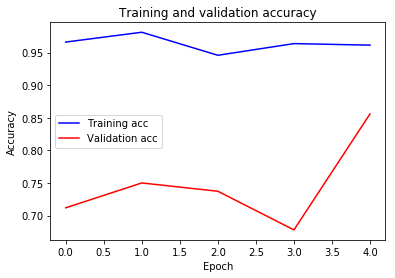

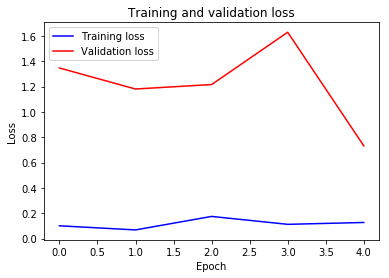

In [18]:
train_histo_vis(history)

### Load Most Recent Model

In [19]:
sgd_fine = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [20]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

(0, 'main_input')
(1, 'Conv2d_1a_7x7_conv')
(2, 'Conv2d_1a_7x7_bn')
(3, 'Conv2d_1a_7x7_act')
(4, 'MaxPool_2a_3x3')
(5, 'Conv2d_2b_1x1_conv')
(6, 'Conv2d_2b_1x1_bn')
(7, 'Conv2d_2b_1x1_act')
(8, 'Conv2d_2c_3x3_conv')
(9, 'Conv2d_2c_3x3_bn')
(10, 'Conv2d_2c_3x3_act')
(11, 'MaxPool_3a_3x3')
(12, 'Mixed_3b_Branch_1_a_1x1_conv')
(13, 'Mixed_3b_Branch_2_a_1x1_conv')
(14, 'Mixed_3b_Branch_1_a_1x1_bn')
(15, 'Mixed_3b_Branch_2_a_1x1_bn')
(16, 'Mixed_3b_Branch_1_a_1x1_act')
(17, 'Mixed_3b_Branch_2_a_1x1_act')
(18, 'Mixed_3b_Branch_3_a_max')
(19, 'Mixed_3b_Branch_0_a_1x1_conv')
(20, 'Mixed_3b_Branch_1_b_3x3_conv')
(21, 'Mixed_3b_Branch_2_b_3x3_conv')
(22, 'Mixed_3b_Branch_3_b_1x1_conv')
(23, 'Mixed_3b_Branch_0_a_1x1_bn')
(24, 'Mixed_3b_Branch_1_b_3x3_bn')
(25, 'Mixed_3b_Branch_2_b_3x3_bn')
(26, 'Mixed_3b_Branch_3_b_1x1_bn')
(27, 'Mixed_3b_Branch_0_a_1x1_act')
(28, 'Mixed_3b_Branch_1_b_3x3_act')
(29, 'Mixed_3b_Branch_2_b_3x3_act')
(30, 'Mixed_3b_Branch_3_b_1x1_act')
(31, 'Mixed_3b_Concatenated')
(

In [21]:
# to get weights and biases of all layers
#for layer in model.layers: print(layer.get_config(), layer.get_weights())

In [22]:
# we will freeze all layers
for i in range(len(model.layers)):
    model.layers[i].trainable=False

## Fine-Tuning for Coarse Classifier

In [23]:
y_train_c = np.dot(y_train,fine2coarse)
y_val_c = np.dot(y_val,fine2coarse)

In [24]:
if GGN:
    # Inception
    net = Conv2D(1024, 1, strides=1, padding='same', activation='relu')(model.layers[-8].output)
    net = Conv2D(1152, 2, strides=1, padding='same', activation='relu')(net)
else:
    # NiN
    net = Conv2D(1024, 1, strides=1, padding='same', activation='relu')(model.layers[-8].output)
    net = Conv2D(1152, 2, strides=1, padding='same', activation='relu')(net)
net = Dropout(.6)(net)
net = MaxPooling2D((2, 2), padding='same')(net)

net = Flatten()(net)
net = Dense(1152, activation='relu')(net)
out_coarse = Dense(20, activation='softmax')(net)

model_c = Model(inputs=in_layer,outputs=out_coarse)
model_c.compile(optimizer= sgd_coarse, loss='categorical_crossentropy', metrics=['accuracy'])

# model.load_weights('data/models/model_coarse'+str(10)+'.h5')

# for i in range(len(model_c.layers)-1):
#     model_c.layers[i].set_weights(model.layers[i].get_weights())

In [25]:
#model.load_weights('data/models/model_coarse'+str(10)+'.h5')

for i in range(len(model_c.layers)-1):
    model_c.layers[i].set_weights(model.layers[i].get_weights())

In [26]:
index = 30
step = 10
stop = 40

while index < stop:
    history = model_c.fit(x_train, y_train_c, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_val, y_val_c), callbacks=[tbCallBack])
    index += step

Train on 2123 samples, validate on 236 samples
Epoch 31/40
2123/2123 [==============================] - 12s 5ms/step - loss: 0.4069 - acc: 0.8874 - val_loss: 0.6811 - val_acc: 0.8475
Epoch 32/40
2123/2123 [==============================] - 10s 5ms/step - loss: 0.1324 - acc: 0.9585 - val_loss: 0.5724 - val_acc: 0.8602
Epoch 33/40
2123/2123 [==============================] - 11s 5ms/step - loss: 0.0924 - acc: 0.9699 - val_loss: 0.5608 - val_acc: 0.8771
Epoch 34/40
2123/2123 [==============================] - 11s 5ms/step - loss: 0.0759 - acc: 0.9779 - val_loss: 0.6150 - val_acc: 0.8814
Epoch 35/40
2123/2123 [==============================] - 11s 5ms/step - loss: 0.0791 - acc: 0.9764 - val_loss: 0.6834 - val_acc: 0.8602
Epoch 36/40
2123/2123 [==============================] - 11s 5ms/step - loss: 0.0860 - acc: 0.9741 - val_loss: 0.7000 - val_acc: 0.8517
Epoch 37/40
2123/2123 [==============================] - 11s 5ms/step - loss: 0.0660 - acc: 0.9797 - val_loss: 0.5824 - val_acc: 0.8814
E

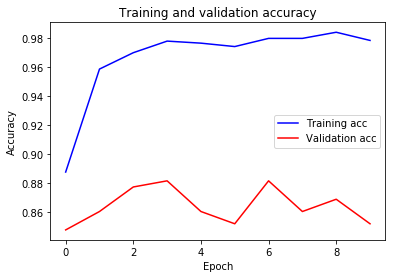

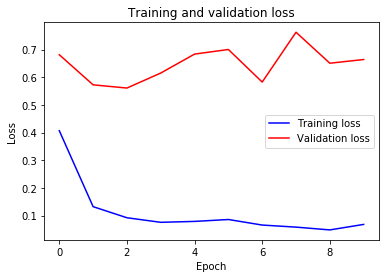

In [27]:
train_histo_vis(history)

In [28]:
model_c.compile(optimizer=sgd_fine, loss='categorical_crossentropy', metrics=['accuracy'])
stop = 50

while index < stop:
    history = model_c.fit(x_train, y_train_c, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_val, y_val_c), callbacks=[tbCallBack])
    index += step

Train on 2123 samples, validate on 236 samples
Epoch 41/50
2123/2123 [==============================] - 12s 6ms/step - loss: 0.0316 - acc: 0.9901 - val_loss: 0.5850 - val_acc: 0.8856
Epoch 42/50
2123/2123 [==============================] - 11s 5ms/step - loss: 0.0262 - acc: 0.9915 - val_loss: 0.5783 - val_acc: 0.8856
Epoch 43/50
2123/2123 [==============================] - 11s 5ms/step - loss: 0.0197 - acc: 0.9934 - val_loss: 0.5836 - val_acc: 0.8941
Epoch 44/50
2123/2123 [==============================] - 11s 5ms/step - loss: 0.0262 - acc: 0.9934 - val_loss: 0.5900 - val_acc: 0.8898
Epoch 45/50
2123/2123 [==============================] - 11s 5ms/step - loss: 0.0218 - acc: 0.9939 - val_loss: 0.5905 - val_acc: 0.8941
Epoch 46/50
2123/2123 [==============================] - 11s 5ms/step - loss: 0.0217 - acc: 0.9934 - val_loss: 0.5818 - val_acc: 0.8898
Epoch 47/50
2123/2123 [==============================] - 11s 5ms/step - loss: 0.0236 - acc: 0.9929 - val_loss: 0.5782 - val_acc: 0.8983
E

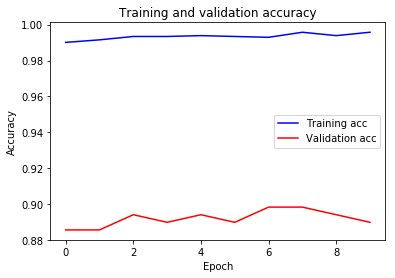

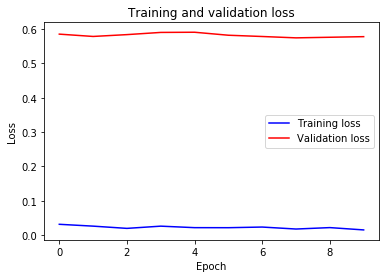

In [29]:
train_histo_vis(history)

## Fine-Tuning for Fine Classifiers

### Construct Fine Classifiers

In [30]:
def fine_model():
    net = Conv2D(1024, 1, strides=1, padding='same', activation='relu')(model.layers[-8].output)
    net = Conv2D(1152, 2, strides=1, padding='same', activation='relu')(net)
    net = Dropout(.2)(net)
    net = MaxPooling2D((2, 2), padding='same')(net)

    net = Flatten()(net)
    net = Dense(1152, activation='elu')(net)
    out_fine = Dense(61, activation='softmax')(net)
    model_fine = Model(inputs=in_layer,outputs=out_fine)
    model_fine.compile(optimizer= sgd_coarse,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    for i in range(len(model_fine.layers)-1):
        model_fine.layers[i].set_weights(model.layers[i].get_weights())
    return model_fine

In [31]:
fine_models = {'models' : [{} for i in range(coarse_categories)], 'yhf' : [{} for i in range(coarse_categories)]}
for i in range(coarse_categories):
    model_i = fine_model()
    fine_models['models'][i] = model_i

### Train Fine Classifiers on Respective Data

In [32]:
def get_error(y,yh):
    # Threshold 
    yht = np.zeros(np.shape(yh))
    yht[np.arange(len(yh)), yh.argmax(1)] = 1
    # Evaluate Error
    error = np.count_nonzero(np.count_nonzero(y-yht,1))/len(y)
    return error

In [33]:
for i in range(coarse_categories):
    index= 0
    step = 5
    stop = 5
    
    # Get all training data for the coarse category
    ix = np.where([(y_train[:,j]==1) for j in [k for k, e in enumerate(fine2coarse[:,i]) if e != 0]])[1]
    x_tix = x_train[ix]
    y_tix = y_train[ix]
    
    # Get all validation data for the coarse category
    ix_v = np.where([(y_val[:,j]==1) for j in [k for k, e in enumerate(fine2coarse[:,i]) if e != 0]])[1]
    x_vix = x_val[ix_v]
    y_vix = y_val[ix_v]
    
    while index < stop:
        history = fine_models['models'][i].fit(x_tix, y_tix, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_vix, y_vix))
        index += step
    train_histo_vis(history)
    
    fine_models['models'][i].compile(optimizer=sgd_fine, loss='categorical_crossentropy', metrics=['accuracy'])
    stop = 10

    while index < stop:
        history = fine_models['models'][i].fit(x_tix, y_tix, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_vix, y_vix))
        index += step
    train_histo_vis(history)
        
    yh_f = fine_models['models'][i].predict(x_val[ix_v], batch_size=batch)
    print('Fine Classifier '+str(i)+' Error: '+str(get_error(y_val[ix_v],yh_f))) 

Train on 165 samples, validate on 18 samples
Epoch 1/5
165/165 [==============================] - 4s 24ms/step - loss: 1.1667 - acc: 0.7394 - val_loss: 0.7996 - val_acc: 0.8889
Epoch 2/5
165/165 [==============================] - 1s 5ms/step - loss: 0.1363 - acc: 0.9818 - val_loss: 0.5762 - val_acc: 0.8889
Epoch 3/5
165/165 [==============================] - 1s 5ms/step - loss: 0.1464 - acc: 0.9576 - val_loss: 0.4877 - val_acc: 0.8889
Epoch 4/5
165/165 [==============================] - 1s 6ms/step - loss: 0.1598 - acc: 0.9697 - val_loss: 0.7808 - val_acc: 0.8889
Epoch 5/5
165/165 [==============================] - 1s 6ms/step - loss: 0.0888 - acc: 0.9818 - val_loss: 0.6125 - val_acc: 0.8889
Train on 165 samples, validate on 18 samples
Epoch 6/10
165/165 [==============================] - 3s 17ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.6093 - val_acc: 0.8889
Epoch 7/10
165/165 [==============================] - 1s 5ms/step - loss: 0.0345 - acc: 0.9939 - val_loss: 0.5685 - val_a

## Probabilistic Averaging

def eval_hdcnn(X, y):
    yh = np.zeros(np.shape(y))
    
    yh_s = model.predict(X, batch_size=batch)
    
    print('Single Classifier Error: '+str(get_error(y,yh_s)))
    
    yh_c = model_c.predict(X, batch_size=batch)
    y_c = np.dot(y,fine2coarse)
    
    print('Coarse Classifier Error: '+str(get_error(y_c,yh_c)))

    for i in range(coarse_categories):
        if i%5 == 0:
            print("Evaluating Fine Classifier: ", str(i))
        #fine_models['yhf'][i] = fine_models['models'][i].predict(X, batch_size=batch)
        yh += np.multiply(yh_c[:,i].reshape((len(y)),1), fine_models['yhf'][i])
    
    print('Overall Error: '+str(get_error(y,yh)))
    return yh

yh = eval_hdcnn(x_val,y_val)

In [34]:
X = x_val; y = y_val

yh = np.zeros(np.shape(y))

yh_s = model.predict(X, batch_size=batch)

print('Single Classifier Error: '+str(get_error(y,yh_s)))

yh_c = model_c.predict(X, batch_size=batch)
y_c = np.dot(y,fine2coarse)

print('Coarse Classifier Error: '+str(get_error(y_c,yh_c)))

for i in range(coarse_categories):
    if i%5 == 0:
        print("Evaluating Fine Classifier: "+ str(i))
    fine_models['yhf'][i] = fine_models['models'][i].predict(X, batch_size=batch)
    yh += np.multiply(yh_c[:,i].reshape((len(y)),1), fine_models['yhf'][i])

print('Overall Error: '+str(get_error(y,yh)))

Single Classifier Error: 0
Coarse Classifier Error: 0
Evaluating Fine Classifier: 0
Evaluating Fine Classifier: 5
Evaluating Fine Classifier: 10
Evaluating Fine Classifier: 15
Overall Error: 0


In [35]:
# Get error function: Debug
yht = np.zeros(np.shape(yh))
yht[np.arange(len(yh)), yh.argmax(1)] = 1
# Evaluate Error
error = np.count_nonzero(np.count_nonzero(y-yht,1))/len(y)
error

0

In [37]:
np.count_nonzero(np.count_nonzero(y-yht,1))

41